In [1]:
# Install necessary libraries
!pip install -q contractions emoji textblob autocorrect wordcloud textstat

# Download NLTK resources
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Core
import pandas as pd
import numpy as np
import re
import string
import warnings
warnings.filterwarnings("ignore")

# NLP
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import TextBlob
import contractions
import emoji
from autocorrect import Speller
import textstat

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


In [3]:
df = pd.read_csv(r"C:\Users\HP\Desktop\NLP_Project\biLSTM+Word2Vec Model\BERT+biLSTM training data.csv")

# Keep relevant columns and clean
df = df[['statement', 'status']].drop_duplicates(subset='statement')
df = df[df['status'].notnull()].reset_index(drop=True)
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79821 entries, 0 to 79820
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  79821 non-null  object
 1   status     79821 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB
None


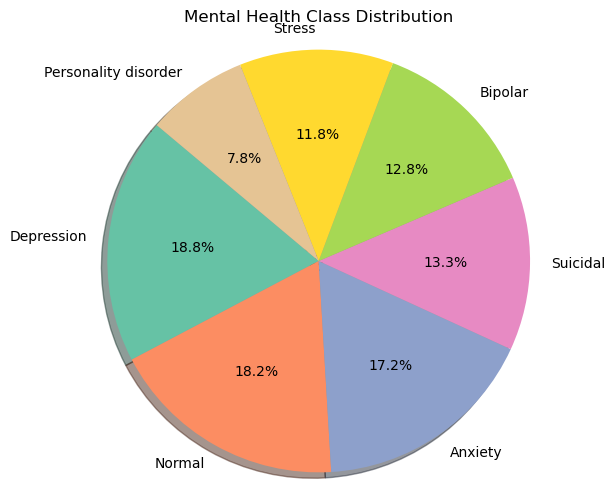

In [4]:
# Pie Chart of classes
status_counts = df['status'].value_counts()
colors = sns.color_palette("Set2", len(status_counts))

plt.figure(figsize=(6, 6))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=140, colors=colors, shadow=True)
plt.title('Mental Health Class Distribution')
plt.axis('equal')
plt.show()


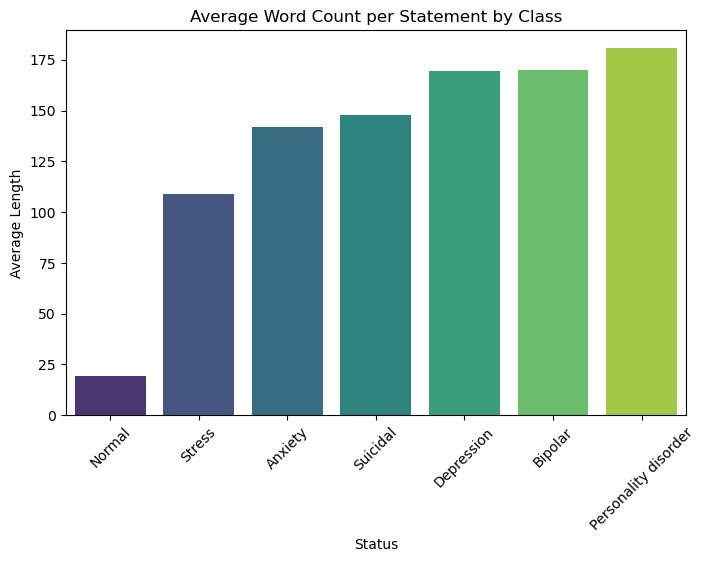

In [5]:
df['text_length'] = df['statement'].apply(lambda x: len(str(x).split()))
avg_lengths = df.groupby('status')['text_length'].mean().sort_values()

plt.figure(figsize=(8, 5))
sns.barplot(x=avg_lengths.index, y=avg_lengths.values, palette='viridis')
plt.title("Average Word Count per Statement by Class")
plt.xlabel("Status")
plt.ylabel("Average Length")
plt.xticks(rotation=45)
plt.show()

In [6]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text):
    text = text.lower()
    text = contractions.fix(text)
    text = re.sub(r"http\S+|@\S+|#[A-Za-z0-9_]+|[^a-zA-Z\s]", "", text)
    return text.strip()

df['statement'] = df['statement'].astype(str).apply(clean_text)
df['tokens'] = df['statement'].apply(word_tokenize)
df['tokens'] = df['tokens'].apply(lambda x: [stemmer.stem(w) for w in x if w not in stop_words])

df[['statement', 'tokens', 'status']].head()


,statement,tokens,status
0,trouble sleeping confused mind restless heart ...,"[troubl, sleep, confus, mind, restless, heart,...",Anxiety
1,all wrong back off dear forward doubt stay in ...,"[wrong, back, dear, forward, doubt, stay, rest...",Anxiety
2,i ve shifted my focus to something else but i ...,"[shift, focu, someth, els, still, worri]",Anxiety
3,i m restless and restless it s been a month no...,"[restless, restless, month, boy, mean]",Anxiety
4,every break you must be nervous like something...,"[everi, break, must, nervou, like, someth, wro...",Anxiety


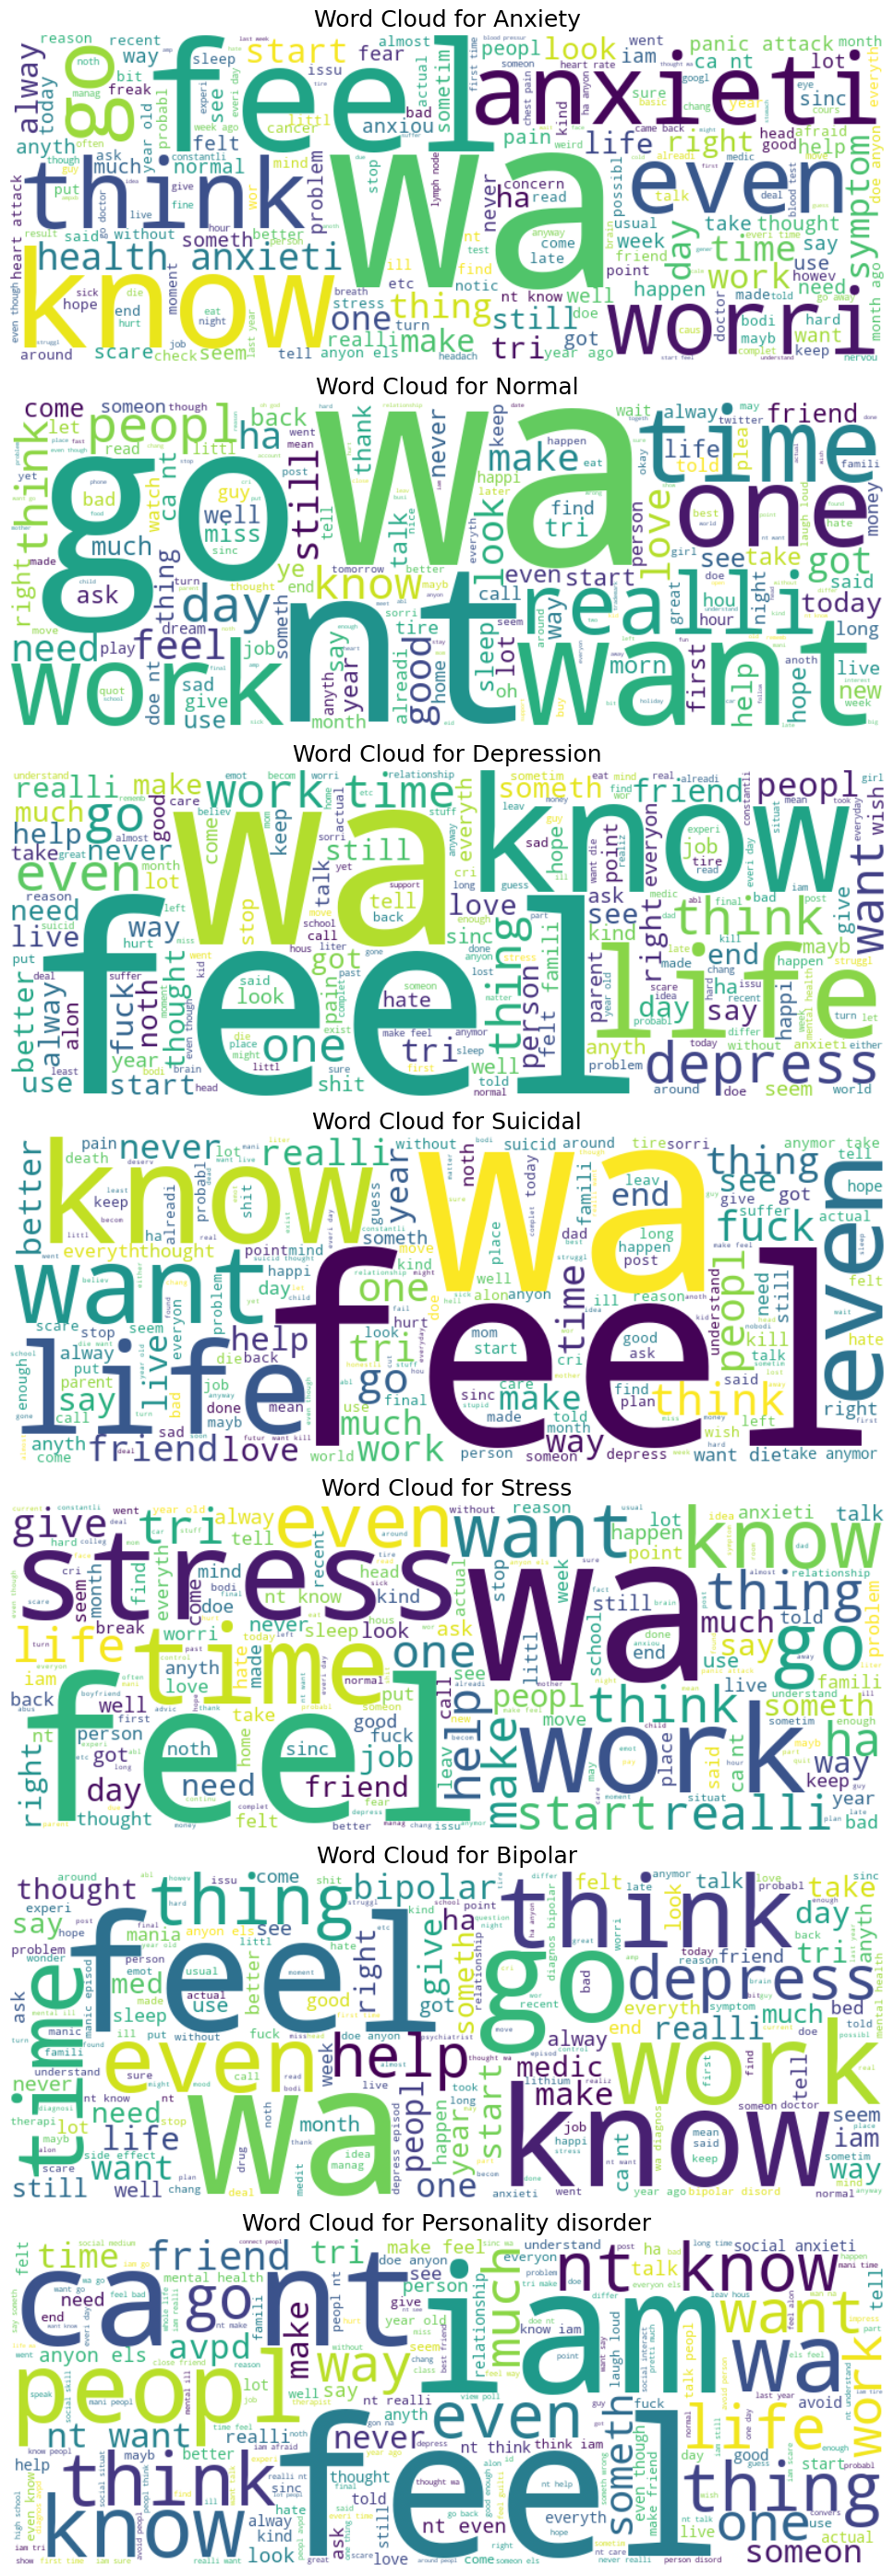

In [7]:
plt.figure(figsize=(16, 4 * len(df['status'].unique())))
for i, cls in enumerate(df['status'].unique()):
    tokens = df[df['status'] == cls]['tokens'].apply(lambda x: ' '.join(x))
    wordcloud = WordCloud(width=800, height=300, background_color='white').generate(' '.join(tokens))
    
    plt.subplot(len(df['status'].unique()), 1, i + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for {cls}", fontsize=18)

plt.tight_layout()
plt.show()


In [8]:
# Text Input → Tokenization → Embedding (Word2Vec) → LSTM Network → Prediction

In [1]:
!pip install -q gensim nltk

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import gensim.downloader as api
import pickle
import logging
import re
import string
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Dropout, GaussianNoise, Lambda, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import CategoricalCrossentropy

# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Logging suppression for gensim
logging.getLogger('gensim').setLevel(logging.ERROR)
logging.getLogger('urllib3').setLevel(logging.ERROR)


In [2]:
 # Load and Clean Text

In [3]:
import pandas as pd

# Load dataset
df = pd.read_csv(r"C:\Users\HP\Desktop\NLP_Project\biLSTM+Word2Vec Model\final_balanced_dataset.csv")
df.dropna(inplace=True)

# already cleaned cleaning
X_text = df['statement']   
y_labels = df['status']
df[['statement', 'status']].head(20)




,statement,status
0,but then i could not think directly now i rece...,Stress
1,is there any way to sleep better i can not sle...,Anxiety
2,always really hyperactive when panic let me sa...,Bipolar
3,doe anyone ever feel like they think of suicid...,Depression
4,i have been always told that i wa a burden a w...,Stress
5,you know that woman with the big boob,Normal
6,i have been suffering from depression and anxi...,Depression
7,i forget a lot lately one second i know what i...,Depression
8,feeling of dread and despair i have an overwhe...,Bipolar
9,am. i have my the my miss the everything. beca...,Depression


In [4]:
# Encode Labels and Tokenize

In [5]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (
    Input, Embedding, LSTM, Bidirectional, Dense, Dropout,
    LayerNormalization, GaussianNoise, SpatialDropout1D, Add, Layer
)
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import AdamW
from tqdm import tqdm
import gensim.downloader as api

# -------------------------------
# 1. Label Encoding
# -------------------------------
label_enc = LabelEncoder()
y_int = label_enc.fit_transform(y_labels)  # y_labels must be your target label list
y_cat = to_categorical(y_int)

# -------------------------------
# 2. Tokenization & Padding
# -------------------------------
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_text)  # X_text must be your list of raw text samples
X_seq = tokenizer.texts_to_sequences(X_text)
X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post')

# -------------------------------
# 3. Load Word2Vec Google News 300D
# -------------------------------
print("Loading Word2Vec model...")
word2vec = api.load("word2vec-google-news-300")
print("Model loaded!")

embedding_dim = 300  
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in tqdm(word_index.items(), desc="Creating embedding matrix"):
    if i >= num_words:
        continue
    try:
        embedding_matrix[i] = word2vec[word]
    except KeyError:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

# -------------------------------
# 4. Augmentation Layer (Train Only)
# -------------------------------
class AugmentNoiseAndScale(tf.keras.layers.Layer):
    def call(self, x, training=None):
        if training:
            noise = tf.random.normal(tf.shape(x), mean=0.0, stddev=0.01)
            scale = tf.random.uniform([tf.shape(x)[0], 1, 1], minval=0.9, maxval=1.1)
            return (x + noise) * scale
        return x

# -------------------------------
# 5. Attention Layer
# -------------------------------
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(
            name="att_weight",
            shape=(input_shape[-1], 1),
            initializer='random_normal',
            trainable=True
        )
        super(AttentionLayer, self).build(input_shape)

    def call(self, inputs):
        score = tf.matmul(inputs, self.W)
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = tf.reduce_sum(inputs * attention_weights, axis=1)
        return context_vector

# -------------------------------
# 6. Model Architecture
# -------------------------------
lstm_units = 64  # changed from 128 to 64
num_classes = y_cat.shape[1]

input_layer = Input(shape=(max_len,), name='input')

# Word2Vec Embedding Layer
x = Embedding(
    input_dim=num_words,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_len,
    trainable=True  # fine-tuning embeddings
)(input_layer)

x = SpatialDropout1D(0.3)(x)
x = GaussianNoise(0.1)(x)
x = AugmentNoiseAndScale()(x)

# First BiLSTM
lstm1 = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
lstm1 = Dropout(0.4)(lstm1)

# Second BiLSTM with Residual Connection
lstm2 = Bidirectional(LSTM(lstm_units, return_sequences=True))(lstm1)
lstm2 = Add()([lstm1, lstm2])  # Residual connection

# Dual Attention
att1 = AttentionLayer()(lstm2)  # Word-level
att2 = AttentionLayer()(lstm1)  # Sentence-level
merged_att = Add()([att1, att2])

# Dense layers
x = LayerNormalization()(merged_att)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-5))(x)
x = Dropout(0.4)(x)

output = Dense(num_classes, activation='softmax', name='output')(x)

model = Model(inputs=input_layer, outputs=output)
model.summary()

# -------------------------------
# 7. Compile Model
# -------------------------------
loss_fn = CategoricalCrossentropy(label_smoothing=0.05)
optimizer = AdamW(learning_rate=3e-4, weight_decay=1e-4, clipnorm=1.0)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# -------------------------------
# 8. Callbacks
# -------------------------------
callbacks = [
    ModelCheckpoint("best_rnn_model_improved.h5", monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-6, verbose=1)
]

# -------------------------------
# 9. Train/Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_pad, y_cat, test_size=0.2, random_state=42, stratify=y_cat
)

# -------------------------------
# 10. Train Model
# -------------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=15,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Loading Word2Vec model...
Model loaded!


Creating embedding matrix: 100%|█████████████████████████████████████████████| 79196/79196 [00:00<00:00, 430675.29it/s]
C:\Users\HP\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)            │ (None, 100)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 100, 300)          │       3,000,000 │ input[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ spatial_dropout1d             │ (None, 100, 300)          │               0 │ embedding[0][0]            │
│ (SpatialDropout1D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gaussian_noise                │ (None, 100, 300)          │               0 │ spatial_dropout1d[0][0]    │
│ (GaussianNoise)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ augment_noise_and_scale       │ (None, 100, 300)          │               0 │ gaussian_noise[0][0]       │
│ (AugmentNoiseAndScale)        │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional (Bidirectional) │ (None, 100, 128)          │         186,880 │ augment_noise_and_scale[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 100, 128)          │               0 │ bidirectional[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_1               │ (None, 100, 128)          │          98,816 │ dropout[0][0]              │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 100, 128)          │               0 │ dropout[0][0],             │
│                               │                           │                 │ bidirectional_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention_layer               │ (None, 128)               │             128 │ add[0][0]                  │
│ (AttentionLayer)              │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ attention_layer_1             │ (None, 128)               │             128 │ dropout[0][0]              │
│ (AttentionLayer)              │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 128)               │               0 │ attention_layer[0][0],     │
│                               │                           │                 │ attention_layer_1[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization           │ (None, 128)               │             256 │ add_1[0][0]                │
│ (LayerNormalization)          │                           │               

 Total params: 3,303,623 (12.60 MB)

 Trainable params: 3,303,623 (12.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.4223 - loss: 1.5470
Epoch 1: val_loss improved from inf to 0.90077, saving model to best_rnn_model_improved.h5


1230/1230 ━━━━━━━━━━━━━━━━━━━━ 461s 361ms/step - accuracy: 0.4224 - loss: 1.5468 - val_accuracy: 0.7210 - val_loss: 0.9008 - learning_rate: 3.0000e-04
Epoch 2/15
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.7004 - loss: 0.9728
Epoch 2: val_loss improved from 0.90077 to 0.77912, saving model to best_rnn_model_improved.h5


1230/1230 ━━━━━━━━━━━━━━━━━━━━ 515s 371ms/step - accuracy: 0.7005 - loss: 0.9728 - val_accuracy: 0.7780 - val_loss: 0.7791 - learning_rate: 3.0000e-04
Epoch 3/15
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.7614 - loss: 0.8367
Epoch 3: val_loss improved from 0.77912 to 0.71860, saving model to best_rnn_model_improved.h5


1230/1230 ━━━━━━━━━━━━━━━━━━━━ 522s 387ms/step - accuracy: 0.7614 - loss: 0.8367 - val_accuracy: 0.8015 - val_loss: 0.7186 - learning_rate: 3.0000e-04
Epoch 4/15
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.7953 - loss: 0.7543
Epoch 4: val_loss improved from 0.71860 to 0.68436, saving model to best_rnn_model_improved.h5


1230/1230 ━━━━━━━━━━━━━━━━━━━━ 519s 401ms/step - accuracy: 0.7954 - loss: 0.7543 - val_accuracy: 0.8170 - val_loss: 0.6844 - learning_rate: 3.0000e-04
Epoch 5/15
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.8206 - loss: 0.6965
Epoch 5: val_loss improved from 0.68436 to 0.65891, saving model to best_rnn_model_improved.h5


1230/1230 ━━━━━━━━━━━━━━━━━━━━ 544s 442ms/step - accuracy: 0.8206 - loss: 0.6965 - val_accuracy: 0.8280 - val_loss: 0.6589 - learning_rate: 3.0000e-04
Epoch 6/15
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.8408 - loss: 0.6479
Epoch 6: val_loss improved from 0.65891 to 0.63440, saving model to best_rnn_model_improved.h5


1230/1230 ━━━━━━━━━━━━━━━━━━━━ 543s 427ms/step - accuracy: 0.8408 - loss: 0.6479 - val_accuracy: 0.8403 - val_loss: 0.6344 - learning_rate: 3.0000e-04
Epoch 7/15
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.8562 - loss: 0.6137
Epoch 7: val_loss improved from 0.63440 to 0.62152, saving model to best_rnn_model_improved.h5


1230/1230 ━━━━━━━━━━━━━━━━━━━━ 629s 511ms/step - accuracy: 0.8562 - loss: 0.6137 - val_accuracy: 0.8462 - val_loss: 0.6215 - learning_rate: 3.0000e-04
Epoch 8/15
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.8681 - loss: 0.5827
Epoch 8: val_loss improved from 0.62152 to 0.61242, saving model to best_rnn_model_improved.h5


1230/1230 ━━━━━━━━━━━━━━━━━━━━ 618s 502ms/step - accuracy: 0.8681 - loss: 0.5827 - val_accuracy: 0.8521 - val_loss: 0.6124 - learning_rate: 3.0000e-04
Epoch 9/15
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.8784 - loss: 0.5620
Epoch 9: val_loss improved from 0.61242 to 0.60598, saving model to best_rnn_model_improved.h5


1230/1230 ━━━━━━━━━━━━━━━━━━━━ 621s 505ms/step - accuracy: 0.8784 - loss: 0.5620 - val_accuracy: 0.8546 - val_loss: 0.6060 - learning_rate: 3.0000e-04
Epoch 10/15
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.8903 - loss: 0.5361
Epoch 10: val_loss improved from 0.60598 to 0.60507, saving model to best_rnn_model_improved.h5


1230/1230 ━━━━━━━━━━━━━━━━━━━━ 631s 512ms/step - accuracy: 0.8903 - loss: 0.5361 - val_accuracy: 0.8561 - val_loss: 0.6051 - learning_rate: 3.0000e-04
Epoch 11/15
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8985 - loss: 0.5137
Epoch 11: val_loss did not improve from 0.60507
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 2239s 2s/step - accuracy: 0.8985 - loss: 0.5137 - val_accuracy: 0.8560 - val_loss: 0.6068 - learning_rate: 3.0000e-04
Epoch 12/15
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.9068 - loss: 0.4974
Epoch 12: val_loss improved from 0.60507 to 0.59302, saving model to best_rnn_model_improved.h5


1230/1230 ━━━━━━━━━━━━━━━━━━━━ 578s 470ms/step - accuracy: 0.9068 - loss: 0.4974 - val_accuracy: 0.8628 - val_loss: 0.5930 - learning_rate: 3.0000e-04
Epoch 13/15
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - accuracy: 0.9127 - loss: 0.4802
Epoch 13: val_loss did not improve from 0.59302
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 1140s 927ms/step - accuracy: 0.9127 - loss: 0.4802 - val_accuracy: 0.8610 - val_loss: 0.6032 - learning_rate: 3.0000e-04
Epoch 14/15
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.9195 - loss: 0.4650
Epoch 14: val_loss improved from 0.59302 to 0.58946, saving model to best_rnn_model_improved.h5


1230/1230 ━━━━━━━━━━━━━━━━━━━━ 640s 520ms/step - accuracy: 0.9195 - loss: 0.4649 - val_accuracy: 0.8674 - val_loss: 0.5895 - learning_rate: 3.0000e-04
Epoch 15/15
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.9266 - loss: 0.4485
Epoch 15: val_loss did not improve from 0.58946
1230/1230 ━━━━━━━━━━━━━━━━━━━━ 591s 480ms/step - accuracy: 0.9266 - loss: 0.4485 - val_accuracy: 0.8680 - val_loss: 0.5955 - learning_rate: 3.0000e-04


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict class probabilities
y_pred_probs = model.predict(X_test)  
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)  

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_enc.classes_,
            yticklabels=label_enc.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=label_enc.classes_))

In [26]:

# Text Input → Tokenization → Embedding (Word2Vec) → LSTM Network → Prediction